## 讀入套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 資料整理

In [3]:
(X_train, y_train0), (X_test, y_test0) = datasets.fashion_mnist.load_data() #使用fashion_mnist的dataset
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
x = Input(shape=(784,))

## 建立VAE

In [15]:
enc_1 = Dense(100, activation='sigmoid') 
enc_2 = Dense(350, activation='sigmoid') ##調整參數
enc_3 = Dense(787, activation='sigmoid') ##多增加一層

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(150, activation='sigmoid') 
dec_2 = Dense(320, activation='sigmoid') #多增加一層
dec_1 = Dense(784, activation='sigmoid') 

In [16]:
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon 

In [18]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [19]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [20]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 100)          78500       input_5[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 350)          35350       dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 787)          276237      dense_17[0][0]                   
____________________________________________________________________________________________

## 建立loss function

In [21]:
reconstruction_loss = 784 * losses.binary_crossentropy(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.7 
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 訓練VAE

In [22]:
VAE.compile(optimizer=Adam())

In [27]:
VAE.fit(X_train,
        batch_size=350, #350
        epochs=12) #訓練12次

Train on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 109us/sample - loss: 279.1663
Epoch 2/12
60000/60000 [==============================] - 7s 111us/sample - loss: 277.0978
Epoch 3/12
60000/60000 [==============================] - 7s 114us/sample - loss: 275.4632
Epoch 4/12
60000/60000 [==============================] - 6s 108us/sample - loss: 273.9213
Epoch 5/12
60000/60000 [==============================] - 7s 116us/sample - loss: 272.6496
Epoch 6/12
60000/60000 [==============================] - 7s 111us/sample - loss: 271.5739
Epoch 7/12
60000/60000 [==============================] - 7s 109us/sample - loss: 270.6955
Epoch 8/12
60000/60000 [==============================] - 7s 108us/sample - loss: 269.7334
Epoch 9/12
60000/60000 [==============================] - 7s 109us/sample - loss: 269.3142
Epoch 10/12
60000/60000 [==============================] - 6s 107us/sample - loss: 268.8133
Epoch 11/12
60000/60000 [==============================] - 7s 118u

## VAE視覺化

In [28]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_17 (Dense)             (None, 350)               35350     
_________________________________________________________________
dense_18 (Dense)             (None, 787)               276237    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 1576      
Total params: 391,663
Trainable params: 391,663
Non-trainable params: 0
_________________________________________________________________


In [29]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 150)               450       
_________________________________________________________________
dense_22 (Dense)             (None, 320)               48320     
_________________________________________________________________
dense_23 (Dense)             (None, 784)               251664    
Total params: 300,434
Trainable params: 300,434
Non-trainable params: 0
_________________________________________________________________


In [30]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 1284 圖的 latent 表示為 [-0.5000878 -2.0239325]


In [31]:
indices = np.random.randint(X_train.shape[0], size=3000)

In [32]:
VAE_latents = VAE_Encoder.predict(X_train[indices])

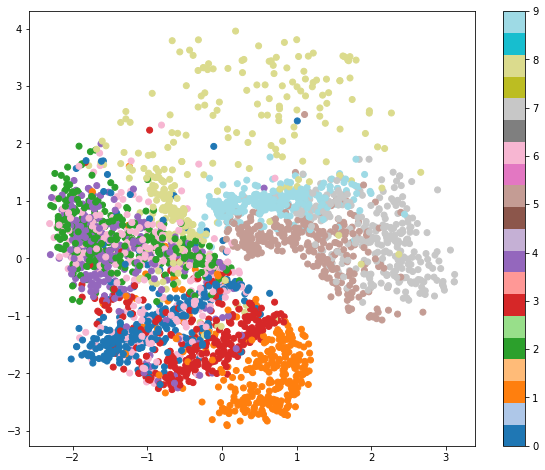

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()